### Creating a Query and Loading a Dataset

In [1]:
from rdkit import Chem
from rdkit.Chem import rdDistGeom, rdForceFieldHelpers
from rdkit.Chem.Draw import IPythonConsole

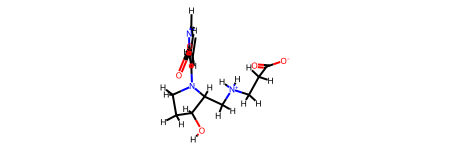

In [2]:
# query = Chem.MolFromSmiles("c1ccnc(C(=O)O)c1N2CCC(O)C2")
query = Chem.MolFromSmiles("c1ccnc(C(=O)O)c1N2CCC(O)C2C[NH2+]CCC(=O)[O-]")
query = Chem.AddHs(query)

ps = rdDistGeom.ETKDGv3()
ps.randomSeed = 0xd06f00d
ps.numThreads = 16

rdDistGeom.EmbedMultipleConfs(query, 10, ps)
rdForceFieldHelpers.MMFFOptimizeMolecule(query)

query

100%|██████████| 100/100 [00:01<00:00, 66.70it/s]


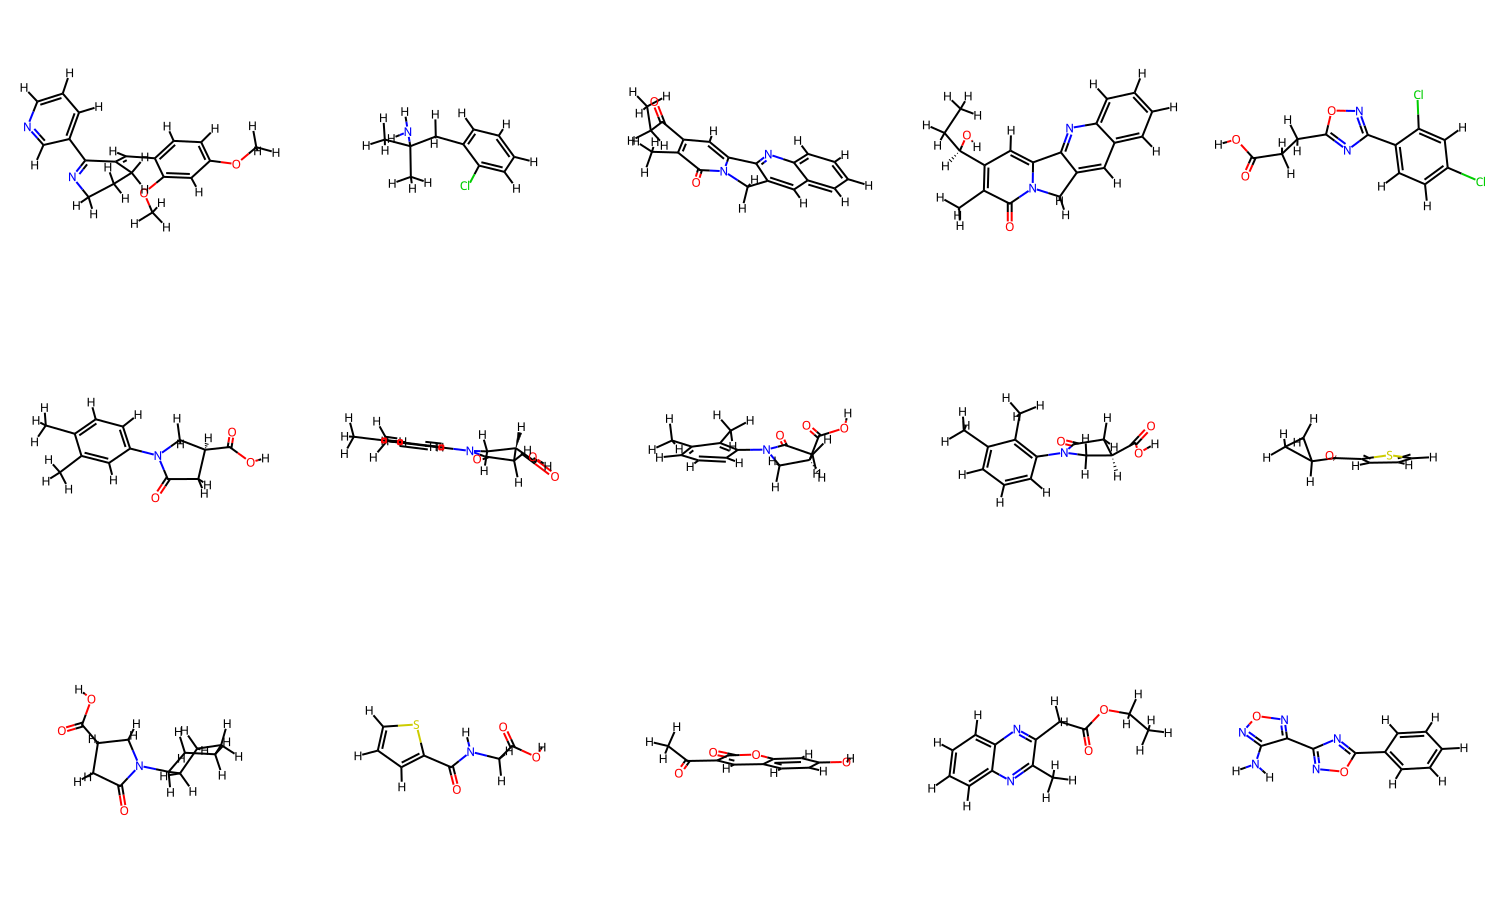

In [3]:
from druglab.storage import MolStorage

mols = [mol for mol in Chem.SmilesMolSupplier("examples.smi", titleLine=False)]
mols = [Chem.AddHs(mol) for mol in mols[:100]]
mols = MolStorage(mols)

mols.generate_conformers(nconfs=10, nworkers=16, optimize=True)

IPythonConsole.ShowMols(mols[:15], molsPerRow=5, subImgSize=(300, 300))

### Creating a Pharmacophore Generator, Profiler, and Fingerprinter

In [4]:
from druglab.pharm import (
    PharmGenerator, BASE_DEFINITIONS_PATH,
    PharmProfiler, PharmDefaultProfiler,
    PharmFingerprinter, PharmCompositeFingerprinter, 
    PharmDistFingerprinter, PharmCosineFingerprinter, PharmTypeIDFingerprinter
)

In [ ]:
pgen = PharmGenerator()
pgen.load_file(BASE_DEFINITIONS_PATH)

profiler = PharmDefaultProfiler(pgen.ftypes, ngroup=3)
distfper = PharmCompositeFingerprinter(
    fpers=[
        PharmDistFingerprinter(bins=(1, 2, 3, 4, 5, 6, 7, 8)),
        PharmDistFingerprinter(bins=(0.5, 1.5, 2.5, 3.5, 4.5, 5.5, 6.5, 7.5))
    ],
    mode="sum"
)
fper = PharmCompositeFingerprinter(
    fpers=[
        PharmTypeIDFingerprinter(),
        distfper,
        PharmCosineFingerprinter(bins=(-0.8, -0.6, -0.4, -0.2, 
                                       0, 0.2, 0.4, 0.6, 0.8))
    ],
    mode="prod",
    fpsize=8192
)

### Manual Generation of Pharmacophore FPs

In [12]:
import numpy as np

# 1) For a single conformer:
pharm = pgen.generate(query)
profile = profiler.profile(pharm)
fp = fper.fingerprint(profile)
print(fp.sum(), fp.shape)

# 2) For all the conformers:
pharm = pgen.generate(query, confid="all")
profile = profiler.profile(pharm)
fps = fper.fingerprint(profile)
print(fps.shape)
print("commonest ids:", np.flip(fps.mean(axis=0).argsort()))

# 3) Or merge all conformers:
fp = fper.fingerprint(profile, merge_confs=True)
print(fp.sum(), fp.shape)

927 (1, 8192)
(10, 8192)
commonest ids: [7865 8001 7753 ... 2022 7270 1543]
5295 (1, 8192)


### Automatically featurizing molecules in a MolStorage or ConformerStorage

In [8]:
from druglab.pharm import PharmFeaturizer

fer = PharmFeaturizer(pgen, profiler, fper)
mols.featurize(fer, overwrite=True)

qfeats = fer.featurize(query)

In [10]:
from scipy.spatial.distance import cdist

cdist(qfeats, mols.feats, metric="dice")

array([[0.92337434, 0.97839224, 0.95760733, 0.88579198, 0.7672187 ,
        0.92315753, 0.92191041, 0.90949914, 0.92450192, 0.99777448,
        0.97234352, 0.89419443, 0.95374686, 0.93470546, 0.86258526,
        0.86125437, 0.86559679, 0.79538679, 0.99925761, 0.96447988,
        0.98529952, 0.98385321, 0.67752905, 0.78255452, 0.99371534,
        0.98385321, 0.9267951 , 0.93711358, 0.79067584, 0.75482685,
        0.71116038, 0.92438299, 0.95087845, 0.97740113, 0.99518875,
        0.88366588, 0.89495295, 0.94212675, 0.94212675, 0.99297597,
        0.87326069, 0.8745164 , 0.9267951 , 0.92315753, 0.91850182,
        0.93011414, 0.97769245, 0.97874679, 0.89267462, 0.91289259,
        0.90494231, 0.90137457, 0.8711739 , 0.8689239 , 0.86417487,
        0.74920006, 0.9245283 , 0.98312855, 0.96990027, 0.72867175,
        0.92505691, 0.94036209, 0.99777448, 0.83958095, 0.85152116,
        0.98603198, 0.70887367, 0.73323331, 0.61565452, 0.78982092,
        0.93181019, 0.91798436, 0.94935806, 0.92

In [20]:
mols.feats.shape

(100, 16384)

(100, 0)

In [5]:
mols.feats

array([], shape=(100, 0), dtype=float32)